In [87]:
# ! pip install ipympl
#! pip install scikit-learn
#! pip install seaborn

In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 데이터 로딩 및 전처리

In [89]:
# 예시 경로, 실제 경로로 수정 필요

# 게임에 참가한 사람들의 고유 정보
participants = pd.read_csv("data/top1000/participants.csv")
# 시간 흐름에 따라 변화하는 실시간 스탯 (골드, 딜량 등) 
participants_frames = pd.read_csv("data/top1000/participant_frames.csv")
# 게임 단위의 결과 (승패 등)
matches = pd.read_csv("data/top1000/matches.csv")
# 킬 이벤트 정보 (누가 누구를 죽였는지)
champ_kill = pd.read_csv('data/top1000/events__CHAMPION_KILL.csv')

In [90]:
# 가장 마지막 프레임만 사용 (게임 종료 시점 상태)
# 게임 종료 시점 기준으로 정보 하나로 묶기
latest_frames = participants_frames.sort_values("frame_timestamp").drop_duplicates(
    subset=["game_id", "participant_id"], keep='last'
)

merged_df = pd.merge(participants, latest_frames, on=["game_id", "participant_id"], how="left")

## 2. KDA 및 주요 파생 지표 생성

### KDA 계산

컬럼 | 의미
---- | ----
kills | 해당 경기에서 몇 번 킬 했는가
deaths | 몇 번 죽었는가
assists | 어시스트 수
KDA | (킬 + 어시스트) / 데스 (생존 기반 전투 영향력)

In [91]:
# kills 수 계산 (킬한 사람 기준)
kills = champ_kill.groupby(["game_id", "killer_id"]).size().reset_index(name="kills")
kills.rename(columns={"killer_id": "participant_id"}, inplace=True)

In [92]:
# deaths 수 계산 (죽은 사람 기준)
deaths = champ_kill.groupby(["game_id", "victim_id"]).size().reset_index(name="deaths")
deaths.rename(columns={"victim_id": "participant_id"}, inplace=True)

In [93]:
# assists 수 계산
assist_df = pd.read_csv("data/top1000/event_assists.csv")

# 게임 ID + 어시스트 참가자 ID로 그룹화
assists = assist_df.groupby(["game_id", "participant_id"]).size().reset_index(name="assists")


In [94]:
# KDA 구하기

# 기본 participant list (merged_df)에서 가져오자
kda_base = merged_df[["game_id", "participant_id", "puuid"]].drop_duplicates()

# 병합
kda_df = (
    kda_base
    .merge(kills, on=["game_id", "participant_id"], how="left")
    .merge(deaths, on=["game_id", "participant_id"], how="left")
)

# 어시스트 컬럼 있으면 병합
if 'assists' in locals():
    kda_df = kda_df.merge(assists, on=["game_id", "participant_id"], how="left")

# 결측값 0으로 채우기
kda_df[["kills", "deaths", "assists"]] = kda_df[["kills", "deaths", "assists"]].fillna(0).astype(int)

# KDA 계산
# 분모가 0이 되면 오류가 나기 때문에, 완벽 생존은 1로 나눈 값을 최대치로 보정
kda_df["KDA"] = (kda_df["kills"] + kda_df["assists"]) / kda_df["deaths"].replace(0, 1)


In [95]:
# merged_df에 병합

merged_df = pd.merge(merged_df, kda_df[["game_id", "participant_id", "kills", "deaths", "assists", "KDA"]],
                     on=["game_id", "participant_id"], how="left")
merged_df.head()

,game_id,participant_id,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,...,totalDamageDone,totalDamageDoneToChampions,totalDamageTaken,trueDamageDone,trueDamageDoneToChampions,trueDamageTaken,kills,deaths,assists,KDA
0,7586549521,1,T2coi9U5HI63yttsRxRgUeQ2xLzedwMv0LWMV_Xtp812gj...,1956361,3780,0,4,18,236,227461,...,221039,38637,35625,26709,13168,3156,13,3,19,10.666667
1,7586549521,2,VzxkuEt2Ay_6P_1wY1FajjdMW8ty20cPLb0jmwqAAjA9Ns...,1956361,1597,0,142,17,22,171344,...,251617,26859,44796,65212,2829,2577,12,10,14,2.600000
2,7586549521,3,-jMFYAy4ogcmItoiwYmQX7tG2fB59CvKQieQwZqYvcLw1x...,1956361,2454,0,8,17,232,259989,...,206296,37478,31216,7563,1790,3254,4,11,19,2.090909
3,7586549521,4,CDtqv-NZS5cmtQI0bsfbxBhq29QlqmwX_YwgG5oW3PkhMm...,1956361,1339,0,16,18,199,130050,...,217726,47278,33657,9483,2649,782,16,11,15,2.818182
4,7586549521,5,72aXoGzHe_SjiP1hNKnMXyx_UYND4_HE2j1Awp9E3l6pge...,1956361,1189,50,0,14,15,226379,...,17701,12926,36143,3208,2008,2392,2,15,23,1.666667


## 유사도 기반 파생 지표 생성 (예시: 시야 점수, 미니언 수, 골드 등)

### 성장 및 경제 지표        

| 지표 | 의미 | 해석 |  
| ---- | ---- | ---- |   
| CS/Min | 분당 미니언 수급량 | 파밍 능력 |     
| Gold/Min | 분당 골드 | 성장 속도 |        
| XP/Min | 분당 경험치 | 레벨 성장 속도 |       




In [96]:
# 성장 및 경제 지표

# 분당 라인 몬스터
merged_df['lane_cs_per_min'] = merged_df['minions_killed'] / (merged_df["frame_timestamp"] / 60000)

# 분당 정글 몬스터
merged_df['jungle_cs_per_min'] = merged_df['jungle_minions_killed'] / (merged_df["frame_timestamp"] / 60000)

# # CS (미니언 + 정글)
# merged_df["cs"] = merged_df["minions_killed"] + merged_df["jungle_minions_killed"]

# # 분당 CS
# merged_df["cs_per_min"] = merged_df["cs"] / (merged_df["frame_timestamp"] / 60000)

# jungle 성향 분석
merged_df['jungle_ratio'] = merged_df['jungle_minions_killed'] / (merged_df['jungle_minions_killed'] + merged_df['minions_killed'])

# 분당 골드
merged_df["gold_per_min"] = merged_df["total_gold"] / (merged_df["frame_timestamp"] / 60000)

# 분당 경험치
merged_df["xp_per_min"] = merged_df["xp"] / (merged_df["frame_timestamp"] / 60000)

### 전투 능력 지표

지표 | 의미 | 해석
---- | ---- | ----
Damage/Min | 분당 딜량 | 전투 기여도
Damage Taken/Min | 분당 받은 피해 | 탱킹 능력 또는 위험 노출
KA/Min | 분당 킬 관여 수 | 싸움 참여율 (적극적인지 여부)
Damage Efficiency | 피해 교환 비율 | 딜 효율 (딜을 얼마나 잘 넣고 덜 맞았는지)

In [97]:
# 전투력 관련 지표
# 분당 피해량
merged_df["damage_per_min"] = merged_df["totalDamageDoneToChampions"] / (merged_df["frame_timestamp"] / 60000)

# 분당 받은 피해량
merged_df["damage_taken_per_min"] = merged_df["totalDamageTaken"] / (merged_df["frame_timestamp"] / 60000)

# 분당 킬 관여율 (K+A)/시간
merged_df["ka_per_min"] = (merged_df["kills"] + merged_df["assists"]) / (merged_df["frame_timestamp"] / 60000)

# 피해 교환 효율 (딜량 / 받은 피해량)
merged_df["damage_efficiency"] = merged_df["totalDamageDoneToChampions"] / merged_df["totalDamageTaken"].replace(0, 1)


### 생존력 지표

지표 | 의미 | 해석
---- | ---- | ----
survivability | 생존률 | 
healthregen_per_min | 분당 체력 재생 | 


In [98]:
# 생존력 지표
# 생존률 (1 - 데스 / 평균 생존시간) → 데스 적을수록 높음
merged_df["survivability"] = 1 / merged_df["deaths"].replace(0, 1)

# 1. healthregen의 총합을 참가자별로 groupby
agg_df = participants_frames.groupby(['game_id', 'participant_id']).agg({
    'healthregen': 'sum',
    'frame_timestamp': 'max'  # 해당 플레이어의 게임 시간 (ms)
}).reset_index()

# 2. 게임 시간(ms)를 분 단위로 변환
agg_df['game_time_min'] = agg_df['frame_timestamp'] / 60000

# 3. 분당 체력 재생량 계산
agg_df['healthregen_per_min'] = agg_df['healthregen'] / agg_df['game_time_min']

# 4. merged_df에 병합 (game_id + participant_id 기준)
merged_df = merged_df.merge(
    agg_df[['game_id', 'participant_id', 'healthregen_per_min']],
    on=['game_id', 'participant_id'],
    how='left'
)

# # 분당 체력 재생
# merged_df["healthregen_per_min"] = merged_df["healthregen"] / (merged_df["frame_timestamp"] / 60000)


### 시야 장악 지표

지표 | 의미 | 해석
---- | ---- | ----
Wards Placed/Min | 분당 설치 | 시야 제공 적극성
Wards Killed/Min | 분당 제거 | 상대 시야 차단 능력
Vision Score Est. | 설치+제거 총합 | 시야 장악 종합 평가 (approx.)

In [99]:
# 포지션 제어 / 시야 장악 지표
wards_placed = pd.read_csv("data/top1000/events__WARD_PLACED.csv")
wards_killed = pd.read_csv("data/top1000/events__WARD_KILL.csv")

## 와드 설치 수
ward_placed_count = (
    wards_placed
    .groupby(["game_id", "creator_id"])
    .size()
    .reset_index(name="wards_placed")
    .rename(columns={"creator_id": "participant_id"})
)

## 와드 제거 수
ward_kill_count = (
    wards_killed
    .groupby(["game_id", "killer_id"])
    .size()
    .reset_index(name="wards_killed")
    .rename(columns={"killer_id": "participant_id"})
)

## merged_df에 와드 수 붙이기
merged_df = (
    merged_df
    .merge(ward_placed_count, on=["game_id", "participant_id"], how="left")
    .merge(ward_kill_count, on=["game_id", "participant_id"], how="left")
)

# 결측치는 0으로 처리
merged_df[["wards_placed", "wards_killed"]] = merged_df[["wards_placed", "wards_killed"]].fillna(0).astype(int)

## 시야 제어 파생 지표 추가
# 분당 와드 설치
merged_df["wards_placed_per_min"] = merged_df["wards_placed"] / (merged_df["frame_timestamp"] / 60000)

# 분당 와드 제거
merged_df["wards_killed_per_min"] = merged_df["wards_killed"] / (merged_df["frame_timestamp"] / 60000)

# 종합 시야 지표 (설치 + 제거)
merged_df["vision_score_est"] = merged_df["wards_placed"] + merged_df["wards_killed"]


### 종합 능력치 지표
기본 아이템 + 능력치 요약

In [100]:
# 아이템/스탯 관련 종합 능력치
# 전체 공격 스탯
merged_df["offensive_score"] = merged_df["attackdamage"] + merged_df["attackspeed"]

# 전체 방어 스탯
merged_df["defensive_score"] = merged_df["armor"] + merged_df["magicresist"]

# 전체 마법 능력치
merged_df["magic_score"] = merged_df["abilitypower"] + merged_df["magicpen"] + merged_df["magicpenpercent"]


생존 또는 스킬 활용 능력

In [101]:
# 기타 유틸성 스탯
# 만능 흡혈 + 물리 흡혈 + 주문 흡혈
merged_df["total_vamp"] = merged_df[["omnivamp", "physicalvamp", "spellvamp"]].sum(axis=1)

# 스킬 쿨다운 영향력
merged_df["haste_score"] = merged_df["cooldownreduction"] + merged_df["abilityhaste"]


In [102]:
merged_df = merged_df.drop(columns = ['game_id', 'participant_id'])

In [103]:
grouped_df = merged_df.groupby('puuid').mean().reset_index()
grouped_df

,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,total_gold,xp,...,wards_placed,wards_killed,wards_placed_per_min,wards_killed_per_min,vision_score_est,offensive_score,defensive_score,magic_score,total_vamp,haste_score
0,--UU6P3gS9XNXShhKrJjdwtMnSJhAhf1UwYbnXkteqewk9...,1.342382e+06,711.428571,35.714286,0.571429,9.571429,53.000000,60737.857143,7107.142857,6357.857143,...,28.714286,7.428571,1.275884,0.329068,36.142857,296.142857,126.571429,49.714286,0.0,0.0
1,-0PkJKNOrIe1cG-0lX_um4tEVXO7QvPRCfcgxaU9JZ9PIf...,1.294763e+06,495.000000,0.000000,41.500000,12.500000,125.000000,321477.000000,8772.500000,10836.000000,...,6.000000,2.000000,0.289675,0.086546,8.000000,285.500000,122.000000,233.000000,0.0,0.0
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,1.648124e+06,1366.000000,0.000000,187.000000,15.000000,10.500000,813079.000000,10567.500000,13827.000000,...,5.500000,8.500000,0.199846,0.307304,14.000000,255.000000,158.500000,263.000000,0.0,0.0
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,1.671957e+06,586.666667,0.000000,0.333333,15.000000,197.000000,431381.000000,11226.000000,13689.666667,...,9.000000,3.000000,0.346756,0.117124,12.000000,213.333333,142.666667,395.666667,0.0,0.0
4,-5HAguWtbg0NJsVdWoBJEpAcb_8m0qXJWCTB9KBOJbC4gD...,1.827048e+06,607.000000,0.000000,8.000000,14.000000,191.000000,60581.000000,11177.000000,12524.000000,...,7.000000,3.000000,0.229879,0.098520,10.000000,453.000000,122.000000,145.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,zuTzJktw2MnWYD9D_fYDG-brT-s577KqtSiDkg6KQQMpfJ...,1.498839e+06,927.666667,50.000000,0.000000,12.000000,25.333333,182773.666667,7246.000000,9259.000000,...,26.000000,4.333333,1.024894,0.168740,30.333333,201.666667,104.666667,187.666667,0.0,0.0
2414,zwyrrvZSzsm3wctHE28o2-6Fyh9rghSWzKJKqQSMaCnLlX...,1.212561e+06,964.000000,0.000000,0.000000,11.200000,169.200000,59283.000000,8886.600000,8361.600000,...,11.000000,2.600000,0.605038,0.134162,13.600000,409.600000,112.600000,10.000000,0.0,0.0
2415,zx3b47b39_fQAz0sueKSYg2MvsXyz3n3yftVu13TLBAvl7...,1.526417e+06,511.600000,50.000000,0.200000,10.600000,27.200000,133081.800000,6721.400000,7799.800000,...,31.600000,7.000000,1.212318,0.277032,38.600000,207.400000,182.600000,45.400000,0.0,0.0
2416,zxeBnmRsYg-hHMiD3q76HrWVNHntwjXehUhFAxkzTc2lR7...,1.926704e+06,922.250000,0.000000,3.750000,16.250000,210.000000,149276.000000,12963.500000,17385.250000,...,6.500000,4.000000,0.203751,0.122225,10.500000,357.250000,193.500000,367.750000,5.0,0.0


## 3. 변수 선택 및 스케일링

In [104]:
features = [
    "kills", "deaths", "assists", "lane_cs_per_min", "jungle_cs_per_min", "jungle_ratio",
    "KDA", "gold_per_min", "xp_per_min",
    "damage_per_min", "damage_taken_per_min", "ka_per_min", "damage_efficiency",
    "survivability", "healthregen_per_min",
    "offensive_score", "defensive_score", "magic_score", "total_vamp", "haste_score",
    "wards_placed_per_min", "wards_killed_per_min", "vision_score_est"
]

In [105]:
filtered_df = grouped_df[features].fillna(0)
filtered_df

,kills,deaths,assists,lane_cs_per_min,jungle_cs_per_min,jungle_ratio,KDA,gold_per_min,xp_per_min,damage_per_min,...,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,haste_score,wards_placed_per_min,wards_killed_per_min,vision_score_est
0,3.000000,6.428571,6.285714,2.541444,0.037034,0.038095,2.726984,326.166208,284.953724,424.448871,...,0.268027,33.636125,296.142857,126.571429,49.714286,0.0,0.0,1.275884,0.329068,36.142857
1,3.500000,4.500000,5.000000,4.605603,2.730754,0.451087,1.800000,396.459185,478.172058,704.375912,...,0.225000,32.174180,285.500000,122.000000,233.000000,0.0,0.0,0.289675,0.086546,8.000000
2,4.500000,2.500000,7.000000,0.382491,6.871390,0.946126,7.750000,387.689206,507.891553,529.058669,...,0.625000,44.342066,255.000000,158.500000,263.000000,0.0,0.0,0.199846,0.307304,14.000000
3,4.000000,5.333333,15.666667,7.273737,0.015468,0.001842,4.263889,406.707915,492.078102,874.762058,...,0.263889,28.844061,213.333333,142.666667,395.666667,0.0,0.0,0.346756,0.117124,12.000000
4,6.000000,6.000000,10.000000,6.272413,0.262719,0.040201,2.666667,367.051112,411.286403,703.429795,...,0.166667,25.188172,453.000000,122.000000,145.000000,0.0,0.0,0.229879,0.098520,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,1.333333,2.000000,21.333333,1.012666,0.000000,0.000000,13.000000,290.812194,358.051157,165.686041,...,0.611111,27.634148,201.666667,104.666667,187.666667,0.0,0.0,1.024894,0.168740,30.333333
2414,4.000000,3.800000,4.000000,8.325295,0.000000,0.000000,2.519048,435.914493,408.449208,521.067938,...,0.428571,28.224096,409.600000,112.600000,10.000000,0.0,0.0,0.605038,0.134162,13.600000
2415,1.800000,6.400000,12.000000,1.136588,0.007083,0.009091,2.564524,264.354897,301.228254,289.321160,...,0.190238,36.240010,207.400000,182.600000,45.400000,0.0,0.0,1.212318,0.277032,38.600000
2416,6.250000,7.500000,8.500000,6.512612,0.108164,0.015846,2.227083,399.508387,535.312137,965.373112,...,0.139583,49.464724,357.250000,193.500000,367.750000,5.0,0.0,0.203751,0.122225,10.500000


In [106]:
# 분산 낮은 거 제거 -> 설명력이 없음
# haste_score 제거
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)  # 예: 분산 1% 미만 제거
selector.fit(filtered_df)
selected_columns = filtered_df.columns[selector.get_support()]
filtered_df = filtered_df[selected_columns]
filtered_df

,kills,deaths,assists,lane_cs_per_min,jungle_cs_per_min,jungle_ratio,KDA,gold_per_min,xp_per_min,damage_per_min,...,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min,vision_score_est
0,3.000000,6.428571,6.285714,2.541444,0.037034,0.038095,2.726984,326.166208,284.953724,424.448871,...,0.624695,0.268027,33.636125,296.142857,126.571429,49.714286,0.0,1.275884,0.329068,36.142857
1,3.500000,4.500000,5.000000,4.605603,2.730754,0.451087,1.800000,396.459185,478.172058,704.375912,...,0.858635,0.225000,32.174180,285.500000,122.000000,233.000000,0.0,0.289675,0.086546,8.000000
2,4.500000,2.500000,7.000000,0.382491,6.871390,0.946126,7.750000,387.689206,507.891553,529.058669,...,0.599451,0.625000,44.342066,255.000000,158.500000,263.000000,0.0,0.199846,0.307304,14.000000
3,4.000000,5.333333,15.666667,7.273737,0.015468,0.001842,4.263889,406.707915,492.078102,874.762058,...,1.505342,0.263889,28.844061,213.333333,142.666667,395.666667,0.0,0.346756,0.117124,12.000000
4,6.000000,6.000000,10.000000,6.272413,0.262719,0.040201,2.666667,367.051112,411.286403,703.429795,...,0.769590,0.166667,25.188172,453.000000,122.000000,145.000000,0.0,0.229879,0.098520,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,1.333333,2.000000,21.333333,1.012666,0.000000,0.000000,13.000000,290.812194,358.051157,165.686041,...,0.562242,0.611111,27.634148,201.666667,104.666667,187.666667,0.0,1.024894,0.168740,30.333333
2414,4.000000,3.800000,4.000000,8.325295,0.000000,0.000000,2.519048,435.914493,408.449208,521.067938,...,0.860420,0.428571,28.224096,409.600000,112.600000,10.000000,0.0,0.605038,0.134162,13.600000
2415,1.800000,6.400000,12.000000,1.136588,0.007083,0.009091,2.564524,264.354897,301.228254,289.321160,...,0.382798,0.190238,36.240010,207.400000,182.600000,45.400000,0.0,1.212318,0.277032,38.600000
2416,6.250000,7.500000,8.500000,6.512612,0.108164,0.015846,2.227083,399.508387,535.312137,965.373112,...,0.813215,0.139583,49.464724,357.250000,193.500000,367.750000,5.0,0.203751,0.122225,10.500000


<Axes: >

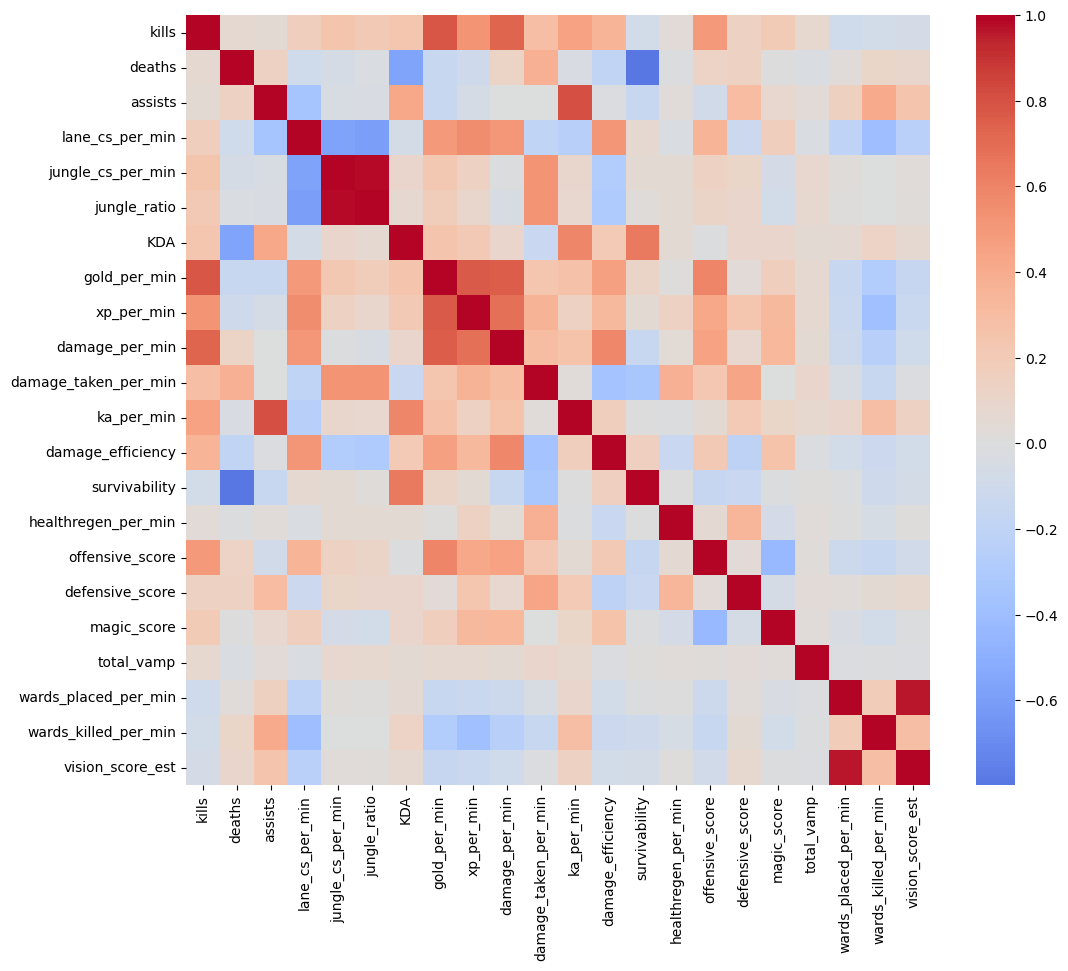

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = filtered_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)

In [108]:
import pandas as pd

# 상관계수 행렬
corr_matrix = filtered_df.corr().abs()

# 자기 자신과의 상관관계는 제외
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 상삼각행렬 마스킹
corr_matrix_masked = corr_matrix.mask(mask)

# 기준 이상 (ex: 0.8 이상)인 변수쌍 추출
high_corr_pairs = corr_matrix_masked.stack().reset_index()
high_corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# 0.8 이상인 경우만 필터링
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] >= 0.7]

# 출력
print(high_corr_pairs)

            Variable1             Variable2  Correlation
14       jungle_ratio     jungle_cs_per_min     0.984167
229  vision_score_est  wards_placed_per_min     0.960431
57         ka_per_min               assists     0.809713
79      survivability                deaths     0.797452
21       gold_per_min                 kills     0.782022
35         xp_per_min          gold_per_min     0.768022
43     damage_per_min          gold_per_min     0.760941
36     damage_per_min                 kills     0.729188


In [109]:
drop_col = ['jungle_ratio', 'vision_score_est', 'deaths', 'assists', 'kills']
filtered_df = filtered_df.drop(columns=drop_col)

In [110]:
# 상관계수 행렬
corr_matrix = filtered_df.corr().abs()

# 자기 자신과의 상관관계는 제외
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 상삼각행렬 마스킹
corr_matrix_masked = corr_matrix.mask(mask)

# 기준 이상 (ex: 0.8 이상)인 변수쌍 추출
high_corr_pairs = corr_matrix_masked.stack().reset_index()
high_corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# 0.8 이상인 경우만 필터링
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] >= 0.8]

# 출력
print(high_corr_pairs)

Empty DataFrame
Columns: [Variable1, Variable2, Correlation]
Index: []


In [111]:
merged_df = pd.concat([grouped_df['puuid'], filtered_df], axis=1)

In [112]:
merged_df.isnull().sum()

puuid                   0
lane_cs_per_min         0
jungle_cs_per_min       0
KDA                     0
gold_per_min            0
xp_per_min              0
damage_per_min          0
damage_taken_per_min    0
ka_per_min              0
damage_efficiency       0
survivability           0
healthregen_per_min     0
offensive_score         0
defensive_score         0
magic_score             0
total_vamp              0
wards_placed_per_min    0
wards_killed_per_min    0
dtype: int64

In [113]:
merged_df

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
0,--UU6P3gS9XNXShhKrJjdwtMnSJhAhf1UwYbnXkteqewk9...,2.541444,0.037034,2.726984,326.166208,284.953724,424.448871,696.504767,0.420603,0.624695,0.268027,33.636125,296.142857,126.571429,49.714286,0.0,1.275884,0.329068
1,-0PkJKNOrIe1cG-0lX_um4tEVXO7QvPRCfcgxaU9JZ9PIf...,4.605603,2.730754,1.800000,396.459185,478.172058,704.375912,946.124550,0.364065,0.858635,0.225000,32.174180,285.500000,122.000000,233.000000,0.0,0.289675,0.086546
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,0.382491,6.871390,7.750000,387.689206,507.891553,529.058669,912.637495,0.423278,0.599451,0.625000,44.342066,255.000000,158.500000,263.000000,0.0,0.199846,0.307304
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,7.273737,0.015468,4.263889,406.707915,492.078102,874.762058,578.421308,0.670765,1.505342,0.263889,28.844061,213.333333,142.666667,395.666667,0.0,0.346756,0.117124
4,-5HAguWtbg0NJsVdWoBJEpAcb_8m0qXJWCTB9KBOJbC4gD...,6.272413,0.262719,2.666667,367.051112,411.286403,703.429795,914.031815,0.525438,0.769590,0.166667,25.188172,453.000000,122.000000,145.000000,0.0,0.229879,0.098520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,zuTzJktw2MnWYD9D_fYDG-brT-s577KqtSiDkg6KQQMpfJ...,1.012666,0.000000,13.000000,290.812194,358.051157,165.686041,306.347812,0.875258,0.562242,0.611111,27.634148,201.666667,104.666667,187.666667,0.0,1.024894,0.168740
2414,zwyrrvZSzsm3wctHE28o2-6Fyh9rghSWzKJKqQSMaCnLlX...,8.325295,0.000000,2.519048,435.914493,408.449208,521.067938,622.513073,0.373584,0.860420,0.428571,28.224096,409.600000,112.600000,10.000000,0.0,0.605038,0.134162
2415,zx3b47b39_fQAz0sueKSYg2MvsXyz3n3yftVu13TLBAvl7...,1.136588,0.007083,2.564524,264.354897,301.228254,289.321160,762.110048,0.527251,0.382798,0.190238,36.240010,207.400000,182.600000,45.400000,0.0,1.212318,0.277032
2416,zxeBnmRsYg-hHMiD3q76HrWVNHntwjXehUhFAxkzTc2lR7...,6.512612,0.108164,2.227083,399.508387,535.312137,965.373112,1202.632165,0.455503,0.813215,0.139583,49.464724,357.250000,193.500000,367.750000,5.0,0.203751,0.122225


In [114]:
merged_df.describe()

,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
count,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000
mean,4.812733,1.155431,4.316925,388.662787,467.888362,660.925595,869.912430,0.552504,0.827353,0.311439,40.709749,350.625189,174.172564,103.428682,0.108976,0.717463,0.173687
std,3.057934,2.087928,3.344298,69.296375,91.220906,259.603466,281.087310,0.218844,0.431718,0.204038,35.090554,112.827551,56.486348,132.846846,1.074386,1.255942,0.115555
min,0.000000,0.000000,0.000000,187.498893,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,7.816207,152.000000,54.000000,0.000000,0.000000,0.000000,0.000000
25%,1.129310,0.000000,2.161616,344.796195,415.537544,485.982984,673.650298,0.413645,0.548087,0.166667,29.186591,244.312500,136.500000,0.000000,0.000000,0.272237,0.093292
50%,6.209254,0.119729,3.500000,397.004494,481.789759,663.507465,831.276798,0.546235,0.760593,0.250000,37.049735,344.109890,164.000000,43.000000,0.000000,0.368526,0.153542
75%,7.436094,0.524605,5.408316,434.182734,528.546445,816.840464,1044.482351,0.679939,1.042972,0.375000,45.050222,436.500000,200.000000,165.375000,0.000000,0.751529,0.233239
max,10.202383,8.238908,28.000000,671.803910,755.269877,2108.894404,3450.252697,1.442956,11.644351,1.000000,1137.199144,1027.000000,620.000000,1065.000000,26.000000,17.606714,0.787834


# 유사도 분석
- 일반 유저와 Top1000 유저 간의 유사도를 수치로 계산
- 가장 유사한 상위 10~20명을 추출

## 유사도 계산용 피처 선택
- 유저의 게임 스타일을 구성하는 성능 지표

카테고리 | 예시 지표 | 의미
------ | ------- | ----
성장 | CS/Min, Gold/Min, XP/Min | 파밍 능력
전투 | KDA, KA/Min, Damage | 교전 참여도
생존 | Survivability, Damage Efficiency | 얼마나 잘 살아남는가
능력치 | offensive_score 등 | 스탯 종합
시야 | wards_placed_per_min 등 | 맵 컨트롤 능력

## 정규화 (Standard Scaler)
- 모든 feature는 단위와 크기가 다르기 때문에, 정규화를 하지 않으면 왜곡된 유사도가 계산

### 💡 StandardScaler 작동 방식     
- 평균을 0으로, 표준편차를 1로 바꾸는 방식        
    → 값의 분포가 동일한 기준에서 비교되도록 조정

In [115]:
# Top 1000 유저 필터링
top1000_puuids = merged_df.sort_values("KDA", ascending=False)["puuid"].unique()[:1000]
merged_df["is_top1000"] = merged_df["puuid"].isin(top1000_puuids)
merged_df

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min,is_top1000
0,--UU6P3gS9XNXShhKrJjdwtMnSJhAhf1UwYbnXkteqewk9...,2.541444,0.037034,2.726984,326.166208,284.953724,424.448871,696.504767,0.420603,0.624695,0.268027,33.636125,296.142857,126.571429,49.714286,0.0,1.275884,0.329068,False
1,-0PkJKNOrIe1cG-0lX_um4tEVXO7QvPRCfcgxaU9JZ9PIf...,4.605603,2.730754,1.800000,396.459185,478.172058,704.375912,946.124550,0.364065,0.858635,0.225000,32.174180,285.500000,122.000000,233.000000,0.0,0.289675,0.086546,False
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,0.382491,6.871390,7.750000,387.689206,507.891553,529.058669,912.637495,0.423278,0.599451,0.625000,44.342066,255.000000,158.500000,263.000000,0.0,0.199846,0.307304,True
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,7.273737,0.015468,4.263889,406.707915,492.078102,874.762058,578.421308,0.670765,1.505342,0.263889,28.844061,213.333333,142.666667,395.666667,0.0,0.346756,0.117124,True
4,-5HAguWtbg0NJsVdWoBJEpAcb_8m0qXJWCTB9KBOJbC4gD...,6.272413,0.262719,2.666667,367.051112,411.286403,703.429795,914.031815,0.525438,0.769590,0.166667,25.188172,453.000000,122.000000,145.000000,0.0,0.229879,0.098520,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,zuTzJktw2MnWYD9D_fYDG-brT-s577KqtSiDkg6KQQMpfJ...,1.012666,0.000000,13.000000,290.812194,358.051157,165.686041,306.347812,0.875258,0.562242,0.611111,27.634148,201.666667,104.666667,187.666667,0.0,1.024894,0.168740,True
2414,zwyrrvZSzsm3wctHE28o2-6Fyh9rghSWzKJKqQSMaCnLlX...,8.325295,0.000000,2.519048,435.914493,408.449208,521.067938,622.513073,0.373584,0.860420,0.428571,28.224096,409.600000,112.600000,10.000000,0.0,0.605038,0.134162,False
2415,zx3b47b39_fQAz0sueKSYg2MvsXyz3n3yftVu13TLBAvl7...,1.136588,0.007083,2.564524,264.354897,301.228254,289.321160,762.110048,0.527251,0.382798,0.190238,36.240010,207.400000,182.600000,45.400000,0.0,1.212318,0.277032,False
2416,zxeBnmRsYg-hHMiD3q76HrWVNHntwjXehUhFAxkzTc2lR7...,6.512612,0.108164,2.227083,399.508387,535.312137,965.373112,1202.632165,0.455503,0.813215,0.139583,49.464724,357.250000,193.500000,367.750000,5.0,0.203751,0.122225,False


In [116]:
merged_df.groupby('puuid').count().reset_index()

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min,is_top1000
0,--UU6P3gS9XNXShhKrJjdwtMnSJhAhf1UwYbnXkteqewk9...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,-0PkJKNOrIe1cG-0lX_um4tEVXO7QvPRCfcgxaU9JZ9PIf...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,-5HAguWtbg0NJsVdWoBJEpAcb_8m0qXJWCTB9KBOJbC4gD...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,zuTzJktw2MnWYD9D_fYDG-brT-s577KqtSiDkg6KQQMpfJ...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2414,zwyrrvZSzsm3wctHE28o2-6Fyh9rghSWzKJKqQSMaCnLlX...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2415,zx3b47b39_fQAz0sueKSYg2MvsXyz3n3yftVu13TLBAvl7...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2416,zxeBnmRsYg-hHMiD3q76HrWVNHntwjXehUhFAxkzTc2lR7...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [117]:
# 스케일링
scaler = StandardScaler()

# 분석 대상에서 제외할 컬럼 지정
id_columns = ['puuid', 'is_top1000']
features = merged_df.drop(columns=id_columns)

# StandardScaler 적용
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features)

# 정규화된 데이터를 다시 DataFrame으로
scaled_features = pd.DataFrame(scaled_array, columns=features.columns, index=features.index)

# 식별자 컬럼 붙이기
scaled_df = pd.concat([merged_df[id_columns], scaled_features], axis=1)

scaled_df

,puuid,is_top1000,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
0,--UU6P3gS9XNXShhKrJjdwtMnSJhAhf1UwYbnXkteqewk9...,False,-0.742906,-0.535760,-0.475517,-0.902060,-2.005817,-0.911104,-0.617045,-0.602842,-0.469519,-0.212807,-0.201624,-0.482981,-0.842876,-0.404417,-0.101452,0.444715,1.344930
1,-0PkJKNOrIe1cG-0lX_um4tEVXO7QvPRCfcgxaU9JZ9PIf...,False,-0.067749,0.754647,-0.752758,0.112531,0.112757,0.167406,0.271189,-0.861244,0.072474,-0.423729,-0.243294,-0.577329,-0.923822,0.975545,-0.101452,-0.340682,-0.754267
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,True,-1.449069,2.738189,1.026758,-0.014052,0.438622,-0.508060,0.152031,-0.590618,-0.528005,1.537098,0.103534,-0.847709,-0.277515,1.201416,-0.101452,-0.412220,1.156546
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,True,0.804960,-0.546091,-0.015862,0.260459,0.265232,0.823875,-1.037227,0.540498,1.570767,-0.233093,-0.338215,-1.217081,-0.557877,2.200266,-0.101452,-0.295224,-0.489594
4,-5HAguWtbg0NJsVdWoBJEpAcb_8m0qXJWCTB9KBOJbC4gD...,False,0.477441,-0.427648,-0.493557,-0.311938,-0.620622,0.163761,0.156992,-0.123706,-0.133826,-0.709683,-0.442421,0.907544,-0.923822,0.312991,-0.101452,-0.388302,-0.650626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,zuTzJktw2MnWYD9D_fYDG-brT-s577KqtSiDkg6KQQMpfJ...,True,-1.242948,-0.553501,2.596919,-1.412351,-1.204328,-1.908072,-2.005360,1.475115,-0.614210,1.469014,-0.372702,-1.320505,-1.230745,0.634230,-0.101452,0.244831,-0.042823
2414,zwyrrvZSzsm3wctHE28o2-6Fyh9rghSWzKJKqQSMaCnLlX...,False,1.148909,-0.553501,-0.537706,0.682020,-0.651731,-0.538847,-0.880333,-0.817740,0.076608,0.574192,-0.355886,0.522807,-1.090269,-0.703427,-0.101452,-0.089533,-0.342115
2415,zx3b47b39_fQAz0sueKSYg2MvsXyz3n3yftVu13TLBAvl7...,False,-1.202415,-0.550108,-0.524105,-1.794230,-1.827373,-1.431727,-0.383599,-0.115420,-1.029948,-0.594134,-0.127404,-1.269679,0.149225,-0.436899,-0.101452,0.394092,0.894521
2416,zxeBnmRsYg-hHMiD3q76HrWVNHntwjXehUhFAxkzTc2lR7...,False,0.556006,-0.501686,-0.625026,0.156543,0.739279,1.172983,1.183933,-0.443334,-0.032756,-0.842447,0.249548,0.058728,0.342232,1.990081,4.553330,-0.409110,-0.445440


In [118]:
# 상위 유저 데이터만 추출
X_top = scaled_df[scaled_df["is_top1000"] == True].fillna(0)
X_top = X_top.drop(columns='is_top1000')
X_top

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,-1.449069,2.738189,1.026758,-0.014052,0.438622,-0.508060,0.152031,-0.590618,-0.528005,1.537098,0.103534,-0.847709,-0.277515,1.201416,-0.101452,-0.412220,1.156546
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,0.804960,-0.546091,-0.015862,0.260459,0.265232,0.823875,-1.037227,0.540498,1.570767,-0.233093,-0.338215,-1.217081,-0.557877,2.200266,-0.101452,-0.295224,-0.489594
8,-AJRi0IczMhxg2SJjU3RrzFhNGgmwUr8zgOUh9FJrpxk7s...,1.479908,-0.488361,0.802449,1.026007,1.937951,0.945747,-0.447273,0.375077,0.904863,0.924340,-0.143595,0.570677,2.511346,-0.778717,-0.101452,-0.318693,-0.718717
9,-AfKDjFub1Lkd135hPxm3JdbEXflbibk_TPvnNm0CTbpWi...,1.582155,-0.490607,1.998762,2.717786,-0.284689,-0.238537,-1.751382,0.775112,1.757297,3.375374,-0.172419,0.730246,-1.331085,-0.778717,-0.101452,-0.257702,0.201234
14,-Ei5YuB1CV4cohstuYkeTX7OrAOIU_bZaRYC7Xu90rOcG4...,-0.757627,-0.530439,0.236013,-0.615307,-0.256245,-0.398840,0.551059,0.494360,-0.618207,-0.342771,0.058229,-0.384961,-0.279286,0.957476,-0.101452,1.470881,1.610038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2407,zhouqznNR0r9OEw6T7G-40hbaN7s5JidMjkxYW97vNF5rW...,-1.251150,2.451827,4.570836,0.865285,1.048362,1.306432,1.926140,0.596732,-0.234300,1.414547,0.214157,0.406676,0.660959,2.812627,-0.101452,0.688208,1.307190
2408,znTmuVKGw2_g_dApzVG2sId1sO0scMTJeeXryiMC-uNysp...,1.308921,-0.494088,0.161293,0.883800,0.842730,0.486871,-0.199061,-0.392917,0.384418,0.525710,-0.138713,0.244039,-0.507026,0.246968,0.328220,-0.337102,-0.345543
2411,zotu_CEvJgKm2YXXMpBmKAehbVqBkiMHgF_xYOFicE_IHd...,0.774709,-0.517860,0.887733,0.279660,1.309771,0.309276,0.452259,0.457430,-0.168917,0.377148,-0.364898,-0.963475,0.063606,1.437916,-0.101452,-0.330975,0.219394
2412,zrBPWcUk5Ql4A5cWw8bB4KSN8VFpREnHWOtPe38IFT3jIz...,0.678550,-0.553501,2.596919,0.344832,0.658684,-0.002615,-0.250619,1.161396,-0.003497,3.375374,0.176669,-1.308685,-1.295671,0.139824,-0.101452,-0.176067,-0.966318


In [119]:
# 유저의 스케일링 데이터
X_target = pd.read_csv("data/result/normal.csv")
X_target = X_target.drop(columns='Unnamed: 0')
X_target

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
0,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,-1.036673,1.466676,0.414888,0.44937,0.206065,0.286351,0.627821,0.696177,-0.264621,-0.167017,1.715338,0.145067,0.076626,0.047672,0.0,0.0,0.0


In [120]:
# 유저의 모든 feature 데이터
X_all = pd.read_csv("data/result/user_all.csv")
X_all = X_all.drop(columns="Unnamed: 0")
X_all

,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,total_gold,xp,...,wards_placed,wards_killed,wards_placed_per_min,wards_killed_per_min,vision_score_est,offensive_score,defensive_score,magic_score,total_vamp,haste_score
0,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,2109058,1854,50,0,15,27,192025,9928,14165,...,0,0,0.0,0.0,0,290,297,73,0,0
1,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,1557593,499,0,105,12,17,196813,10338,9662,...,0,0,0.0,0.0,0,233,190,304,0,0
2,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,2038851,397,0,20,18,254,233832,16991,18776,...,0,0,0.0,0.0,0,669,199,0,0,0
3,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,1563034,1573,0,153,16,21,200243,16437,15699,...,0,0,0.0,0.0,0,317,154,746,0,0
4,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,2468923,4876,0,269,18,86,538127,25905,29530,...,0,0,0.0,0.0,0,677,174,0,0,0
5,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,1831942,1337,50,0,13,31,251263,9157,11206,...,0,0,0.0,0.0,0,218,233,0,0,0
6,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,965237,1129,0,101,11,13,168825,8049,7580,...,0,0,0.0,0.0,0,342,121,0,0,0
7,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,2076960,1024,0,133,16,29,660477,13103,15297,...,0,0,0.0,0.0,0,491,257,0,0,0
8,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,958008,57,0,80,9,6,261910,5205,5534,...,0,0,0.0,0.0,0,329,113,0,0,0
9,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,1429418,489,0,136,13,15,441586,8405,10870,...,0,0,0.0,0.0,0,423,165,24,0,0


## 유사도 계산 (Cosine Similarity)
- 두 벡터(유저)의 방향이 얼마나 비슷한지를 보는 지표

  - 모든 유저를 동일한 척도로 정규화

  - 기준 유저와 Top 유저 각각의 "플레이 스타일 유사도"를 수치화

  - 이제 정량적 비교가 가능해짐 → 추천, 시각화, 군집화 등 모두 이 위에서 진행됨

## 유사도 상위 유저 추출
- 기준 유저와 각 Top 유저 간의 유사도 배열

In [121]:
# 1. 식별자 컬럼 제외하고 feature만 추출
id_cols = ['puuid']
X_top_features = X_top.drop(columns=id_cols)
X_target_features = X_target.drop(columns=id_cols)

# 2. 코사인 유사도 계산 (전체 랭커 vs 신규 유저 1명)
# → 결과 shape: (랭커 수, 1)
similarities = cosine_similarity(X_top_features, X_target_features)

# 3. 결과를 DataFrame에 정리
result_df = X_top[id_cols].copy()
result_df['similarity'] = similarities.ravel()

# 4. 유사도 기준 정렬 (높은 순)
result_df = result_df.sort_values(by='similarity', ascending=False)

# 5. 상위 10명 보기
top_similar_players = result_df.head(10)
print(top_similar_players)

                                                  puuid  similarity
213   4JnyOmP6FcSX5GFchpN67tC1-hmTzLK1-tqSUyKTm_DQ3f...    0.857624
1140  TmpUJu2JbzFa97ZvMLQ2yqr4as7yGaFj-OonNbH-RblhT_...    0.799034
971   OJAxPXIfspXW_n2rvPkJrOXXwB5mLqkMlS1nX122rud9K8...    0.782005
337   7RrgN1eyFL0wZkr7Lx-RslvQnqu7ApDpr0yCRxhn1-m32A...    0.777527
1953  oadLHBtre_qsiiNRv7DAyY9CuZKUvOdkyTYmzv0pF1uxoa...    0.764462
980   OeTHCQQ9uYxn4cqsywYo309tq22tHmK-CGpe2Z7sEiwdfR...    0.759196
746   IDhs-F-Rm1bgsFHAxPKLgam_e2CuYaGx0LZRx3le5AsyeD...    0.754755
1872  m21sZ3e7VYjOGNWh6vDIbpZytSPib1z_c5a2MXVD0GyHDf...    0.754644
417   9Ve6ePaO5Gik_drqm32crw0k2k-boga431tN0zr6JfrqMd...    0.753350
1071  RbQZ9ibUN99dpA1Nru35-jBav9im9zpFzQ450J269J2uRb...    0.750053


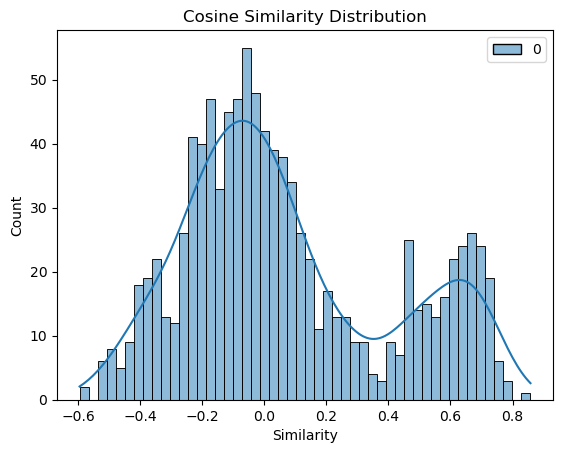

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(similarities, bins=50, kde=True)
plt.title("Cosine Similarity Distribution")
plt.xlabel("Similarity")
plt.ylabel("Count")
plt.show()

# 여기까지

In [123]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [125]:
X_all.columns

Index(['puuid', 'frame_timestamp', 'current_gold', 'gold_per_second',
       'jungle_minions_killed', 'level', 'minions_killed',
       'time_enemy_spent_controlled', 'total_gold', 'xp', 'position_x',
       'position_y', 'abilityhaste', 'abilitypower', 'armor', 'armorpen',
       'armorpenpercent', 'attackdamage', 'attackspeed',
       'bonusarmorpenpercent', 'bonusmagicpenpercent', 'ccreduction',
       'cooldownreduction', 'health', 'healthmax', 'healthregen', 'lifesteal',
       'magicpen', 'magicpenpercent', 'magicresist', 'movementspeed',
       'omnivamp', 'physicalvamp', 'power', 'powermax', 'powerregen',
       'spellvamp', 'magicDamageDone', 'magicDamageDoneToChampions',
       'magicDamageTaken', 'physicalDamageDone',
       'physicalDamageDoneToChampions', 'physicalDamageTaken',
       'totalDamageDone', 'totalDamageDoneToChampions', 'totalDamageTaken',
       'trueDamageDone', 'trueDamageDoneToChampions', 'trueDamageTaken',
       'kills', 'deaths', 'assists', 'KDA', 'lane

In [ ]:
# similarity 기반 거리 → 중심에서의 반지름
top_similar_players = result_df.head(10).copy()
top_similar_players["distance"] = 1 - top_similar_players["similarity"]

# 원형 배치를 위한 각도 분할
angles = np.linspace(0, 2 * np.pi, len(top_similar_players), endpoint=False)
top_similar_players["x"] = np.cos(angles) * top_similar_players["distance"]
top_similar_players["y"] = np.sin(angles) * top_similar_players["distance"]

# 타겟 유저 중앙에 고정
target_user_row = {
    "puuid": X_target["puuid"].values[0],
    "similarity": 1.0,
    "x": 0.0,
    "y": 0.0,
    "KDA": X_all.loc["KDA"].values.mean(),
    "damage_per_min": merged_df.loc[merged_df["puuid"] == target_puuid, "damage_per_min"].values[0],
    "gold_per_min": merged_df.loc[merged_df["puuid"] == target_puuid, "gold_per_min"].values[0],
    "label": "Target",
}
target_user_df = pd.DataFrame([target_user_row])

# 상위 유저 라벨
top_similar_players["label"] = "Top"

# 병합
plot_df = pd.concat([top_similar_players, target_user_df], ignore_index=True)

# 시각화
fig = px.scatter(
    plot_df,
    x="x",
    y="y",
    color="similarity",
    text="label",
    hover_data=["puuid", "similarity"],
    color_continuous_scale="Viridis",
    title="Similarity-based Positioning (Target User = Center, Circular Distance)",
)
fig.update_traces(marker=dict(size=14, line=dict(width=1, color="DarkSlateGrey")))

target_trace = px.scatter(
    target_user_df, x="x", y="y", text=["You"], color_discrete_sequence=["red"]
)
target_trace.update_traces(marker=dict(size=16, symbol="star"))

fig.add_trace(target_trace.data[0])
fig.show()